In [1]:
import random
import numpy as np
import math
from EDR_UTILITY_FUNCTIONS import *

class qTable:
    def __init__(self):
        self.q_values = {}

    def get_state_key(self, state):
        return state

    def get_action_key(self, action):
        consumed_edges, goal_edge = action
        sorted_edges = tuple(sorted(consumed_edges))
        return (sorted_edges, goal_edge)

    def get_q_value(self, state, action):
        key = (self.get_state_key(state), self.get_action_key(action))
        return self.q_values.get(key, 0.0)

    def set_q_value(self, state, action, value):
        key = (self.get_state_key(state), self.get_action_key(action))
        self.q_values[key] = value

def softmax_probs(q_values, temperature=1.0):
    max_q = max(q_values)
    exp_q = [math.exp((q - max_q) / temperature) for q in q_values]
    sum_exp_q = sum(exp_q)
    return [x / sum_exp_q for x in exp_q]

class QuantumNetworkQLearning:
    def __init__(self, edges, goalEdges, pSwap, pGen, maxAge, alpha, gamma, epsilon, softmax, temperature, temperature_decay, bin_size=0.05):
        self.edges = edges
        self.goalEdges = goalEdges
        self.pSwap = pSwap
        self.pGen = pGen
        self.maxAge = maxAge
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.softmax = softmax
        self.temperature = temperature
        self.temperature_decay = temperature_decay
        self.bin_size = bin_size

        self.Q = qTable()
        self.goal_success_queues = {goal: [] for goal in self.goalEdges}

    def choose_action(self, state, training=True):
        ent_state, _ = state
        possible_actions = getPossibleActions(ent_state, self.goalEdges)

        q_scores = [(action, self.Q.get_q_value(state, action)) for action in possible_actions]

        if self.softmax and training:
            q_vals = [q for (_, q) in q_scores]
            probs = softmax_probs(q_vals, self.temperature)
            chosen_action = random.choices([a for a, _ in q_scores], weights=probs)[0]
        else:
            if training and random.random() < self.epsilon:
                chosen_action = random.choice(possible_actions)
            else:
                chosen_action = max(q_scores, key=lambda x: x[1])[0]

        return chosen_action

    def train(self, num_episodes=10, max_steps=1000, plot=False):
        for episode in range(num_episodes):
            ent_state = [(edge, -1) for edge in self.edges]
            edrs = {goal: 0.0 for goal in self.goalEdges}
            state = get_augmented_state(ent_state, edrs, bin_size=self.bin_size, goal_order=self.goalEdges)

            self.goal_success_queues = {goal: [] for goal in self.goalEdges}
            total_timesteps = 1

            for step in range(max_steps):
                action = self.choose_action(state, training=True)
                next_state = performAction(action, state)
                next_state = ageEntanglements(next_state, self.maxAge)
                next_state = generateEntanglement(next_state, self.pGen)

                # Step 1: Add 0s initially to all goal queues
                for g in self.goal_success_queues:
                    self.goal_success_queues[g].append(0)

                # Step 2: Success check and overwrite last entry
                consumed_edges, goal = action
                success = False
                if goal is not None and consumed_edges:
                    success_prob = self.pSwap ** (len(consumed_edges) - 1)
                    success = random.random() < success_prob
                    if success:
                        self.goal_success_queues[goal][-1] = 1

                reward = getReward(
                    action=action,
                    goal_success_queues=self.goal_success_queues,
                    total_timesteps=total_timesteps,
                    pSwap=self.pSwap,
                    success=success
                )

                # Augment new state with updated EDR snapshot
                edr_snapshot = {
                    g: sum(self.goal_success_queues[g]) / max(1, len(self.goal_success_queues[g]))
                    for g in self.goalEdges
                }
                next_state = get_augmented_state(next_state[0], edr_snapshot, bin_size=self.bin_size, goal_order=self.goalEdges)

                # Q-learning update
                old_q = self.Q.get_q_value(state, action)
                possible_next_actions = getPossibleActions(next_state[0], self.goalEdges)
                max_next_q = max([self.Q.get_q_value(next_state, a) for a in possible_next_actions], default=0.0)
                new_q = old_q + self.alpha * (reward + self.gamma * max_next_q - old_q)
                self.Q.set_q_value(state, action, new_q)

                state = next_state
                total_timesteps += 1

            # Optional: Decay temperature
            if self.softmax and self.temperature_decay:
                self.temperature = max(0.01, self.temperature * self.temperature_decay)

            if (episode + 1) % 10 == 0:
                print(f"Episode {episode + 1}")

# === Q-Learning Wrapper for Experiment Framework ===
def train_q_learning_policy(edges, goal_edges, p_swap, p_gen, max_age, seed=None, **kwargs):
    random.seed(seed)
    np.random.seed(seed)

    agent = QuantumNetworkQLearning(
        edges=edges,
        goalEdges=goal_edges,
        pSwap=p_swap,
        pGen=p_gen,
        maxAge=max_age,
        alpha=kwargs.get("alpha", 0.1),
        gamma=kwargs.get("gamma", 0.99),
        epsilon=kwargs.get("epsilon", 0.001),
        softmax=kwargs.get("softmax", False),
        temperature=kwargs.get("temperature", 1.0),
        temperature_decay=kwargs.get("temperature_decay", 0.9),
        bin_size=kwargs.get("bin_size", 0.05)
    )
    agent.train(
        num_episodes=kwargs.get("num_episodes", 5),
        max_steps=kwargs.get("max_steps", 1000),
        plot=False
    )
    return agent.Q


In [21]:
# === Setup parameters ===
edges = [(0, 1), (1, 2), (3, 2), (2, 4), (4, 5)]
goal_edges = [(3, 5), (0, 5)]
pSwap = 0.8
pGen = 0.8
maxAge = 2

from collections import defaultdict
from EDR_UTILITY_FUNCTIONS import qTable
# === Train Q-Learning agent ===
Q = train_q_learning_policy(
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    seed=42,  # optional
    alpha=0.1,
    gamma=0.99,
    epsilon=0.05,
    num_episodes=40,
    max_steps=20000,
    softmax=True,
    temperature=2,
    temperature_decay=0.999
)

# # === Simulate policy (with EDR tracking) ===
# simulate_policy(
#     Q_table=Q,
#     edges=edges,
#     goal_edges=goal_edges,
#     p_swap=pSwap,
#     p_gen=pGen,
#     max_age=maxAge,
#     num_steps=100000,
#     edr_window_size=100,
#     bin_size=0.05,
#     plot=True
# )


Episode 10
Episode 20
Episode 30
Episode 40


Total unique states visited: 3112
Average visits per state: 1004.51
States visited only once: 0
States never visited : 0
States visited less than 10 : 2650


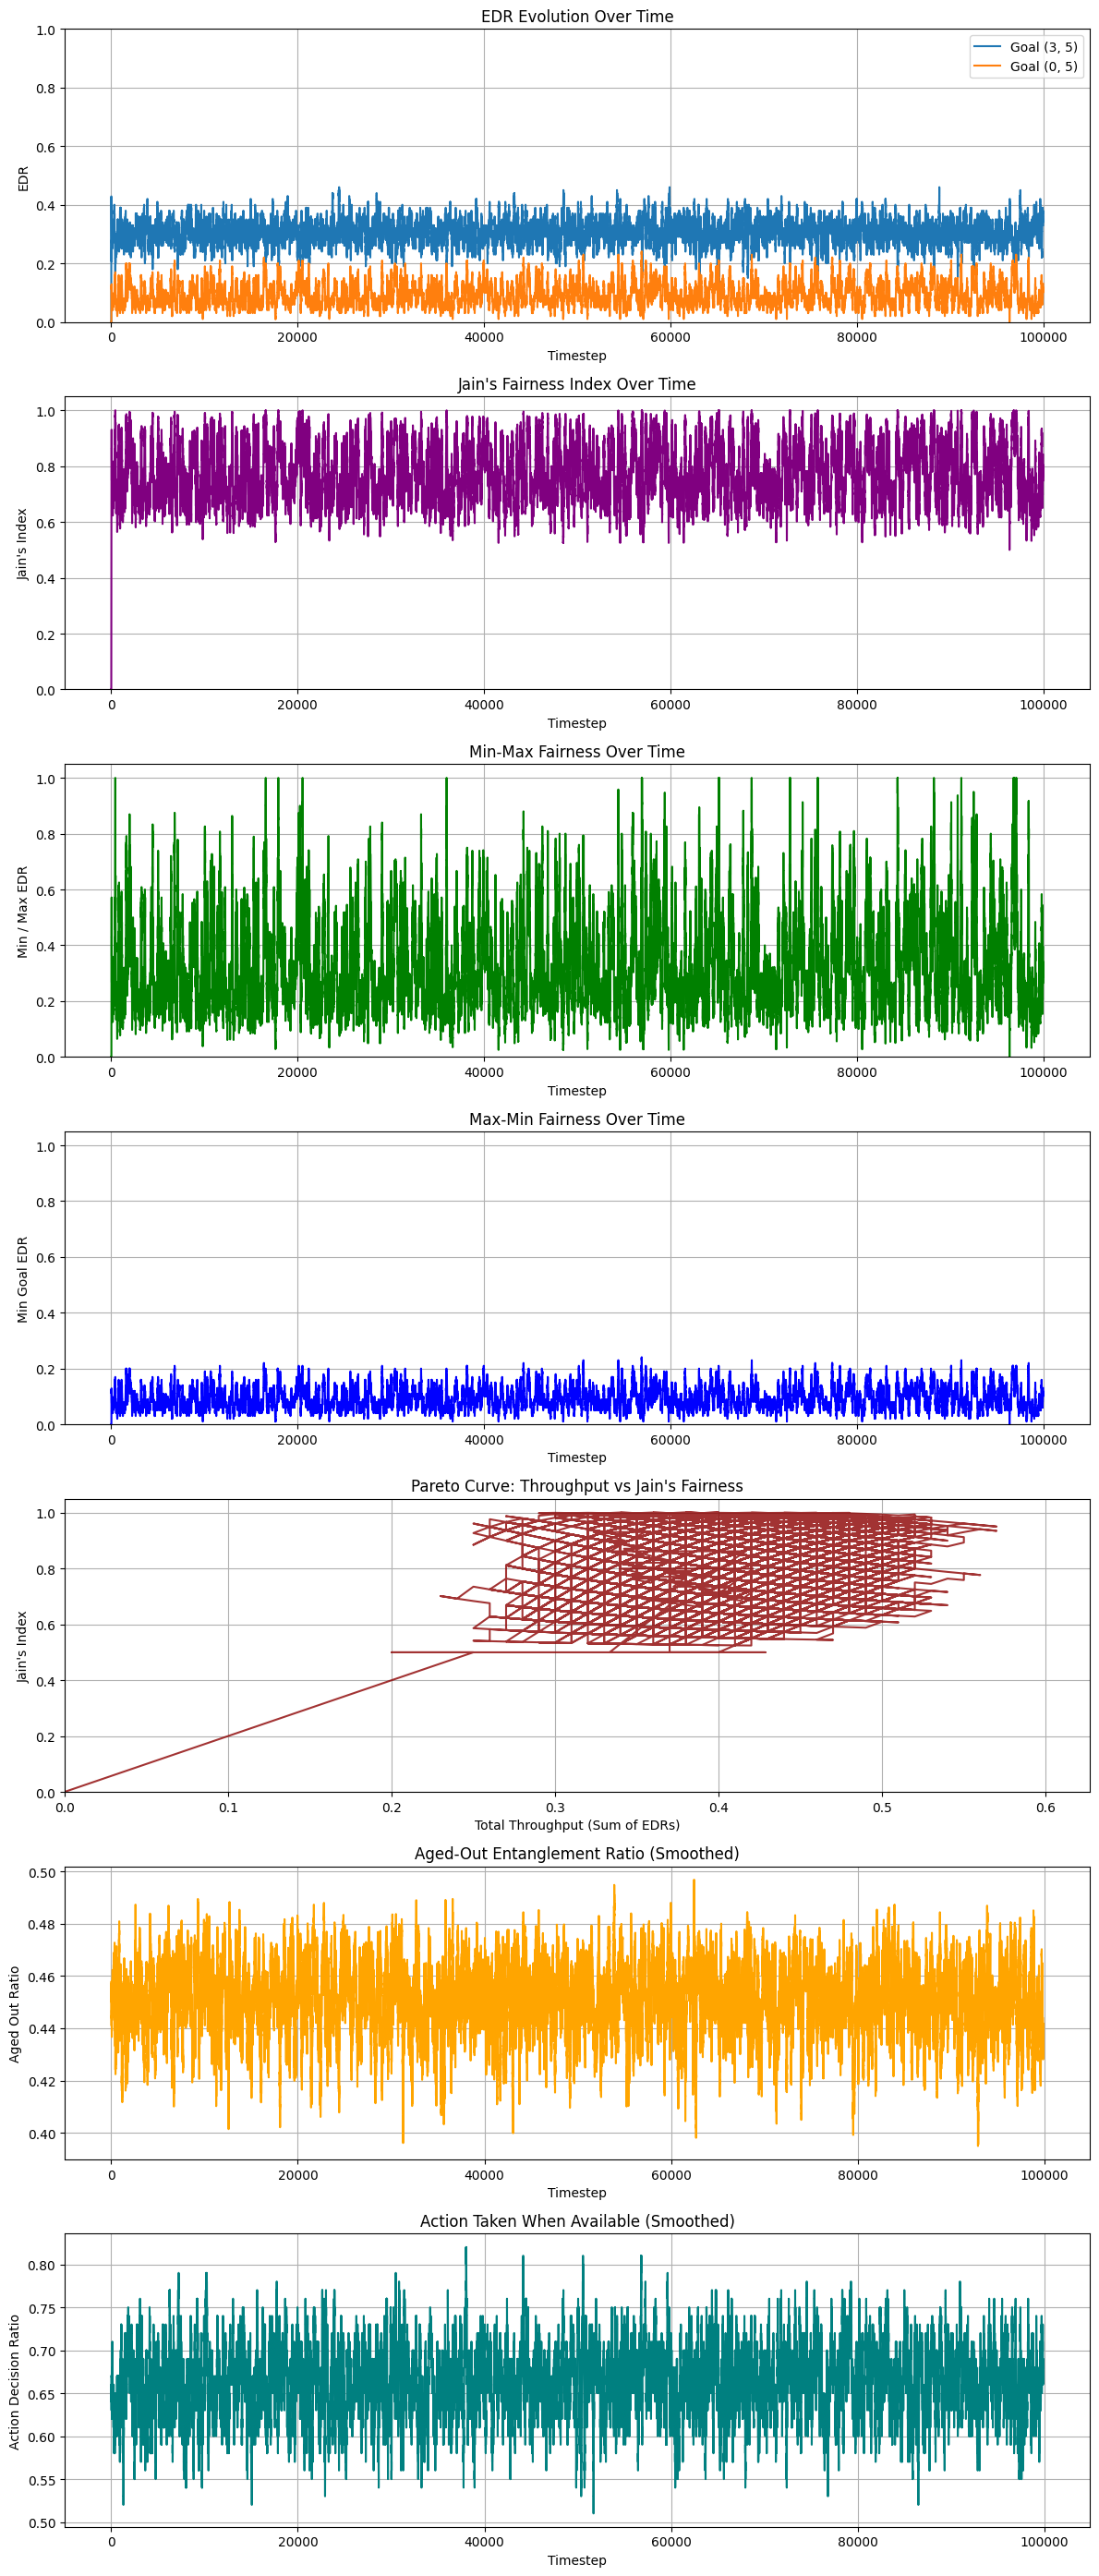

({(3, 5): 30602, (0, 5): 9383},
 100000,
 {(3, 5): [0.0,
   0.0,
   0.0,
   0.25,
   0.2,
   0.3333333333333333,
   0.42857142857142855,
   0.375,
   0.3333333333333333,
   0.4,
   0.36363636363636365,
   0.3333333333333333,
   0.38461538461538464,
   0.35714285714285715,
   0.3333333333333333,
   0.3125,
   0.29411764705882354,
   0.3333333333333333,
   0.3157894736842105,
   0.3,
   0.2857142857142857,
   0.2727272727272727,
   0.30434782608695654,
   0.2916666666666667,
   0.28,
   0.2692307692307692,
   0.25925925925925924,
   0.25,
   0.2413793103448276,
   0.23333333333333334,
   0.22580645161290322,
   0.21875,
   0.21212121212121213,
   0.20588235294117646,
   0.22857142857142856,
   0.2222222222222222,
   0.24324324324324326,
   0.23684210526315788,
   0.2564102564102564,
   0.275,
   0.2682926829268293,
   0.2619047619047619,
   0.2558139534883721,
   0.25,
   0.26666666666666666,
   0.2608695652173913,
   0.2553191489361702,
   0.2708333333333333,
   0.2653061224489796,
   0

In [20]:
print(f"Total unique states visited: {len(Q.state_visits)}")
visits = list(Q.state_visits.values())
print(f"Average visits per state: {np.mean(visits):.2f}")
print(f"States visited only once: {sum(1 for v in visits if v == 1)}")
print(f"States never visited : {sum(1 for v in visits if v == 0)}")
print(f"States visited less than 10 : {sum(1 for v in visits if v <= 100)}")

simulate_policy(
    Q_table=Q,
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=100000,
    edr_window_size=100,
    bin_size=0.05,
    plot=True
)

In [3]:

compare_policies_across_param(
    policy_name="Q-Learning",
    policy_train_fn=train_q_learning_policy,
    param_name="pGen",
    param_values=[0.1 * i for i in range(1, 11)],  # 0.1 to 1.0
    edges=edges,
    goal_edges=goal_edges,
    p_gen=pGen,  # gets overridden
    p_swap=pSwap,
    max_age=maxAge,
    train_kwargs={
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.1,
        "num_episodes": 10,
        "max_steps": 10000,
        "temperature": 1.0,
        "temperature_decay": 0.98,
        "softmax": False
    },
    validate_kwargs={},  # optional
    plot=True,
    num_runs=5,
    num_steps=7000,
    num_simulations=5
)



=== Evaluating Q-Learning for pGen = 0.1 ===

=== Q-Learning (pGen=0.1) Policy Training Run 1 ===
Episode 10

=== Q-Learning (pGen=0.1) Policy Training Run 2 ===


KeyboardInterrupt: 